In [40]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

#Пикабу не пускает без хедеров :с
DEFAULT_HEADERS = {
    "User-Agent": "Mozilla/4.0 (compatible; MSIE 7.0;\ Windows NT 6.0)",
    "Referer": "http://pikabu.ru/",
    "Host": "pikabu.ru",
    "Origin": "pikabu.ru"
}

# Типы сортировки постов по их оценкам и новизне
POSTS_SORT = {"Hot" : "", "Best" : "best/", "New" : "new/"}

class Post():
    """
    Этот класс описывает обьект типа пост, пока что учитываются атрибуты: рейтинг, 
    ссылка на пост, текст, теги и заголовок
    """
    def __init__(self, rating = 0, link = "", text = "", tags = [], title = "", images_count = 0, datetime = ""):
        #добавить: число подписчиков и рейтинг автора
        self.rating = rating
        self.link = link
        self.text = text
        self.tags = tags
        self.title = title
        self.images = images_count
        self.datetime = datetime
        
    def get_tags(self, s):
        all_tags = s.findAll(attrs = ['tags__tag'])
        tags = []
        for i in range(len(all_tags)):
            tag_data = all_tags[i].get("data-tag")
            if not tag_data == None:   
                tags.append(tag_data)
        
        self.tags = tags

    def get_text(self, s):
        text = s.findAll('p')
        result_txt = ""
        for j in range(len(text)):
            result_txt += text[j].text
        self.text = result_txt

    def get_rating(self, s):
        self.rating = s.get('data-rating') 

    def get_link(self, s):
        link = s.find(attrs = ["story__title-link"])
        if not link == None:
            self.link = link['href']
        else:
            self.link = ""
    
    def get_title(self, s):
        title = s.find(attrs = ["story__title-link"])
        if not title == None:
            self.title = title.text
        else:
            self.title = "Ad"
    def get_images(self, s):
        images = s.findAll(attrs = ['story-block story-block_type_image'])
        if not images == None:
            self.images_count = len(images)
        else:
            self.images_count = 0
    def get_datetime(self, s):
        d = s.find(attrs = ["caption story__datetime hint"])
        self.datetime = d['datetime']
        
    def show_data(self):
        print(self.title)
        print(self.rating)
        print(self.link)
        print(self.text)
        print(self.tags)
        print(self.images_count)
        print(self.datetime)
        
class Content():
    """
    Контент со страниц сайта пикабу, 
    количество учитываемых страниц задается через конструктор, 
    также задается тип сортировки
    """
    def __init__(self, sort = 'Hot', pages_count = 10):
        self.posts = []
        self.site_url = 'https://pikabu.ru/' 
        self.pages_count = pages_count
        self.sort = POSTS_SORT[sort]
        self.all_tags = dict()
        
    def get_all_posts(self):
        for i in range(1, self.pages_count):
            r = requests.get(self.site_url + self.sort + "?page=" + str(i), headers=DEFAULT_HEADERS)
            soup = BeautifulSoup(r.text)
            posts_from_page = soup.findAll('article')
            self.get_posts_data(posts_from_page)
            
    def add_new_tags(self, tags):
        for i in tags:
            if i in self.all_tags:
                self.all_tags[i] += 1
            else:
                self.all_tags[i] = 1
            
    def get_posts_data(self, t):        
        for i in range(len(t) - 1):
            post = Post()
            post.get_rating(t[i])
            #Если пост новый или рекламный - оценка None
            #rating = post.rating
            #if (rating == None):
            #    continue
            post.get_link(t[i])
            post.get_text(t[i])
            post.get_tags(t[i])
            post.get_title(t[i])
            post.get_images(t[i])
            post.get_datetime(t[i])
            self.posts.append(post)
            self.add_new_tags(post.tags)
            
    def show_all(self):
        for i in self.posts:
            i.show_data()
            

c = Content("Best", 5)
c.get_all_posts()
#c.show_all()

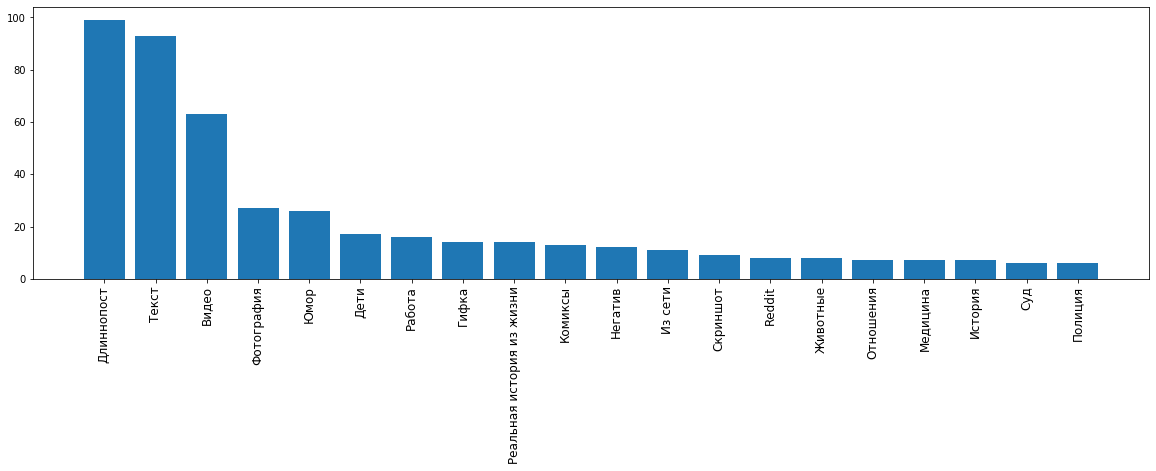

In [3]:
#самые популярные теги за сегодня
import matplotlib.pyplot as plt

def make_nice_plot(all_tags):
    all_tags = list(all_tags.items())
    all_tags.sort(key=lambda i: i[1])
    all_tags = all_tags[::-1]
    
    k = 20 #no more than 30
    best_k_tags = all_tags[:k]
    labels = [i[0] for i in best_k_tags]
    counts = [i[1] for i in best_k_tags]
    pos = [i for i in range(len(best_k_tags))]
    plt.figure(figsize=(k, 5))
    plt.bar(pos, counts)
    plt.xticks(pos, labels, rotation=90, fontsize=12)
    plt.show()
    
make_nice_plot(c.all_tags)

In [41]:
COLUMNS_TITLES = ['title', 'rating', 'text_id', 'tags', 'images_count', 'datetime']
COUNT_OF_ATTRIBUTES = len(COLUMNS_TITLES)
posts = c.posts
simple_table = [[] for i in range(COUNT_OF_ATTRIBUTES)]
all_text = {}


def table_update():
    return pd.DataFrame({COLUMNS_TITLES[i]: simple_table[i] for i in range(COUNT_OF_ATTRIBUTES)})
        
def create_simple_table():
    for i in range(len(posts)):
        all_text[i] = posts[i].text
        rating = posts[i].rating
        if rating == None:
            rating = 0
        else:
            rating = int(rating)
        l = [posts[i].title, rating, i, posts[i].tags, posts[i].images_count, posts[i].datetime]
        for i in range(COUNT_OF_ATTRIBUTES):
            simple_table[i].append(l[i])
    
    return simple_table

def create_csv():
    simple_table = create_simple_table()
    table_of_posts = table_update()
    table_of_posts = table_of_posts[table_of_posts.title != 'Ad'] #Adblock
    table_of_posts = table_of_posts[table_of_posts.tags != '[]']

    table_of_posts.to_csv('ex.csv')
    print(table_of_posts)
create_csv()

                                                title  rating  text_id  \
0            Победитель конкурса на лучший ребрендинг   11504        0   
1   Парня высмеяли в СМИ за то, что он сделал деву...    8433        1   
2                                   I want to believe    8427        2   
3                       Основано на реальных событиях    7869        3   
4                         Новый уровень благодарности    7551        4   
5          Сломались наушники. Как сказать родителям?    7373        5   
6                                           В среднем    6004        6   
7   "Дайте человеку заниматься любимым делом и он ...    4650        7   
8                            Хорошо забытое старое...    4334        8   
9                                         Нужно знать    3882        9   
10                            "Неблагоприятные" семьи    3531       10   
11                                      И это хорошо!    3271       11   
12                                    